In [167]:
# financial data analysis with arhmm

In [168]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [169]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

import numpy as np
import pandas as pd

In [170]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### loading the dataset

In [171]:
data = pd.read_csv("Financial-Data/stocks/TSLA.csv")
data = data.dropna()
data.head()

close_diff = np.diff(np.log(data['Close']))[1:]
close_diff_1 = np.diff(np.log(data['Close']), n=2)

has_nan_close_diff = np.any(np.isnan(close_diff))
has_nan_close_diff_1 = np.any(np.isnan(close_diff_1))

print(has_nan_close_diff)
print(has_nan_close_diff_1)

False
False


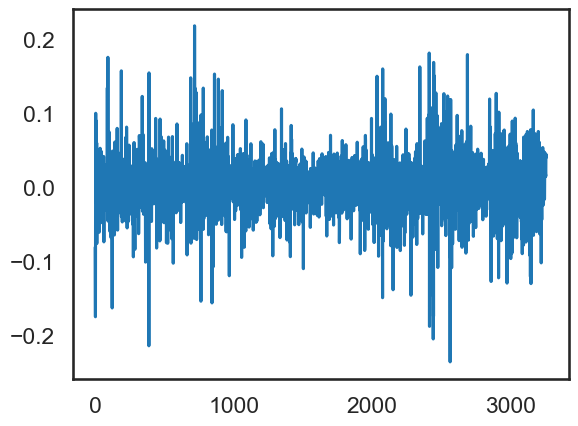

In [172]:
plt.plot(close_diff)

## fitting a model

In [173]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 4
emission_dim = 1
num_lags = 1
start_index = 1500

emissions = close_diff[start_index:]
emissions = (emissions - emissions) / np.std(emissions)
emissions = jnp.array(close_diff[start_index:]).reshape(-1, 1)
time_bins = len(emissions)

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

inputs = arhmm.compute_inputs(emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot the log-likelihood

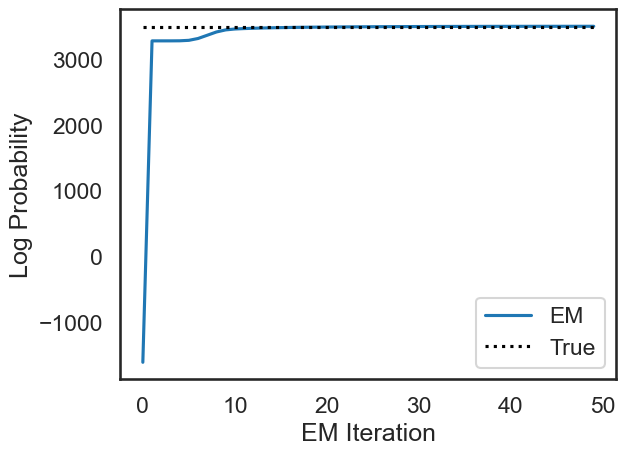

In [174]:
true_lp = arhmm.marginal_log_prob(fitted_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

## inspecting the parameters

In [175]:
# inspecitng the fitted parameters
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.628929  , 0.0735631 , 0.11177289, 0.18573527], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.10759205, 0.00663793, 0.02251237, 0.86325765],
       [0.00958863, 0.9662537 , 0.0163007 , 0.00785694],
       [0.2759992 , 0.01380733, 0.2939218 , 0.41627172],
       [0.46804228, 0.02422224, 0.3749014 , 0.13283412]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.03545011]],

       [[-0.02106259]],

       [[-0.04899843]],

       [[-0.00348961]]], dtype=float32), biases=Array([[ 9.508947e-03],
       [ 3.307377e-03],
       [-8.661983e-03],
       [ 3.902401e-05]], dtype=float32), covs=Array([[[0.00046003]],

       [[0.00300077]],

       [[0.00142437]],

       [[0.000243  ]]], dtype=float32))


# find most likely states

In [176]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

## plot of most likely states

Text(0, 0.5, 'Close Values')

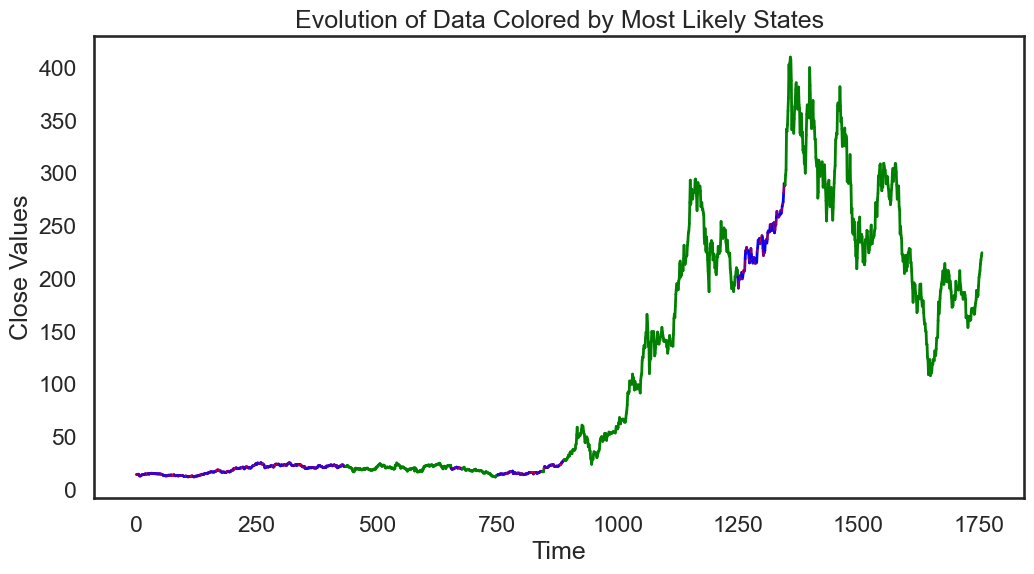

In [178]:
d = data['Close'][start_index:].to_numpy()

colors = ['blue', 'green', 'red', 'purple']
state_colors = [colors[state] for state in most_likely_states]

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(1, len(d)-2):
    ax.plot([i-1, i], [d[i-1], d[i]], color=state_colors[i], linewidth=2)

ax.set_title('Evolution of Data Colored by Most Likely States')
ax.set_xlabel('Time')
ax.set_ylabel('Close Values')

## plot of distribution of hidden states

Text(0.5, 0, 'time')

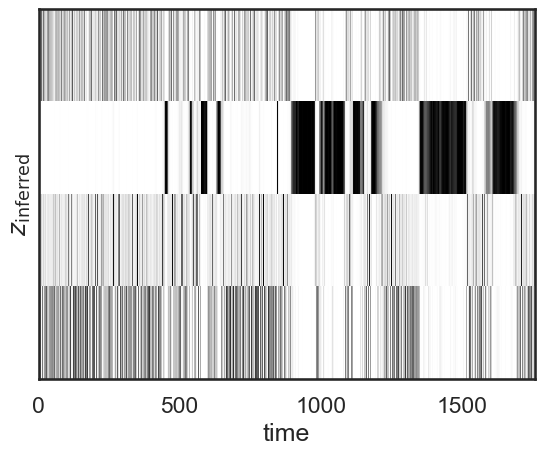

In [179]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

# sample new data and plot them

(1758, 1)


Text(0, 0.5, 'Emissions')

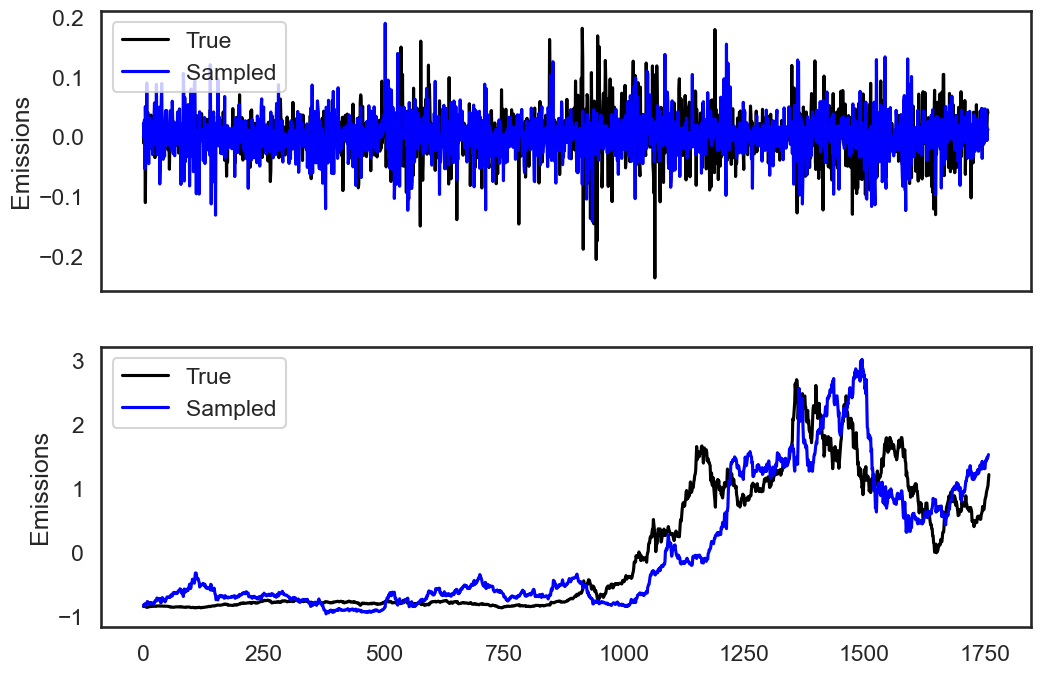

In [180]:
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)

print(sampled_emissions.shape)

initial_value = data['Close'].iloc[start_index]
recovered_log = np.cumsum(np.concatenate(([np.log(initial_value)], sampled_emissions.reshape(-1))))
recovered_series = np.exp(recovered_log)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(emissions, color="black", label="True")
ax[0].plot(sampled_emissions, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")

d = data['Close'][start_index:].to_numpy()
d = (d-np.mean(d))/np.std(d)

recovered_series = (recovered_series - np.mean(recovered_series)) / np.std(recovered_series)

ax[1].plot(d, color="black", label="True")
ax[1].plot(recovered_series, color="blue", label="Sampled")
ax[1].legend(loc="upper left")
ax[1].set_ylabel("Emissions")

In [181]:
initial_value = 0
start = [1,2,3,1,4,5,3,7,4]
converted = np.diff(np.log(start))
print(converted)
recovered_log = np.cumsum(np.concatenate(([np.log(start[0])], converted)))
recovered_series = np.exp(recovered_log)
print(recovered_series)

[ 0.69314718  0.40546511 -1.09861229  1.38629436  0.22314355 -0.51082562
  0.84729786 -0.55961579]
[1. 2. 3. 1. 4. 5. 3. 7. 4.]


Text(0.5, 0, 'time')

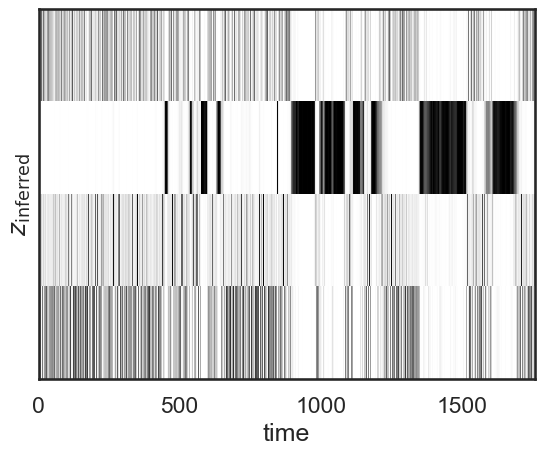

In [182]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")